In [2]:
#가장 널리 사용하는 자연어 처리 라이브러리
import nltk
nltk.__version__
# 실행 후 발생하는 팝업에서 필요한 데이터를 선택해 다운로드하면 된다.
#nltk.download('') 

# 한국어 자연어처리를 위한 라이브러리
import konlpy

# etc
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import re
import os
import csv
from konlpy.utils import pprint
from konlpy.tag import Kkma


In [3]:

from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import urllib.request

#케라스 안 쓰니까 이 셀 필요 x

In [4]:
#엑셀 파일로 저장된 데이터 불러오기

data = pd.read_csv('data.csv')
kkma = Kkma()


In [5]:
#분류 여부가 Y 인 것들 만으로 모델 학습 진행
tf = data['대표여부'] == 'Y'
data = data[tf]
#print(data)
#print("csv 시트의 데이터 타입: ",type(data))

data = data.values     #4개의 칼럼 ('논문고유번호', '태그', '문장', '대표여부') 으로 되어있음
print("length: ",len(data))
print("dimension: ",data.ndim)
print("shape: ", data.shape)

#print(".vlues 의 데이터 타입", type(data))
#print(data[:,2])
np.save('NLP_TextData.npy', data[:,2])
np.save('NLP_LabelData.npy',data[:,1])

TextData = np.load('NLP_TextData.npy', allow_pickle=1)
LabelData = np.load('NLP_LabelData.npy', allow_pickle=1)

#for i in range(len(data)):
#               print(kkma.morphs(data[i,2]))


length:  37168
dimension:  2
shape:  (37168, 4)


성능/효과     7879
대상 데이터    4769
후속연구      4584
데이터처리     4288
문제 정의     4288
제안 방법     4215
기술 정의     3951
이론/모형     2140
가설 설정     1054
dtype: int64


<AxesSubplot:>

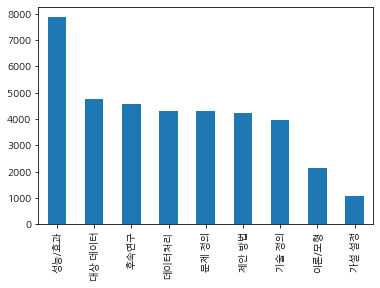

In [9]:
# plt 한글 폰트 깨지는 거 해결 
import matplotlib.font_manager as fm
from matplotlib import rc
    # 윈도우에 기본으로 깔려있는 폰트 뭐뭐 있나 확인하는거
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
font_list[:]
  
rc('font',family="NanumGothic")

# 가진 데이터 태그 분포 확인하기
temp = pd.Series(LabelData)
print(temp.value_counts())
temp.value_counts().plot(kind = 'bar')

In [10]:
#traindata랑 testdata로 나누기
# 문장과 라벨을 섞어줄거다
# 두 ndarray가 동일하게 random.shuffle() 이 적용 되어야 함 << 시발 어떻게?

print("TextData의 크기: ", TextData.shape)
print("LabelData의 크기:", LabelData.shape)

s = np.arange(TextData.shape[0])
np.random.shuffle(s)

TextData = TextData[s]
#print ("셔플 한 뒤의 문장 배열: ", TextData)
LabelData = LabelData[s]
#print ("셔플 한 뒤의 라벨 배열: ", LabelData)  >> ㅇㅇㅇ

# train : test = 8 : 2 으로 나눠보쟝
from sklearn.model_selection import train_test_split

Text_train, Text_test = train_test_split(TextData, test_size=0.2, shuffle=False)
Label_train, Label_test = train_test_split(LabelData, test_size=0.2, shuffle=False)

TextData의 크기:  (37168,)
LabelData의 크기: (37168,)


In [11]:
print(len(Text_train), len(Text_test))
print(len(Label_train), len(Label_test))

print(Text_train[1004])
print(Label_train[1004])

29734 7434
29734 7434
2 등급 지반에서 측압계수(K0)는 1.0과 1.5, 토피고는 40 m, 50 m, 60 m, 확폭형상은 박스형과 아치형, 보강방법은 무지보와 록볼트로 총 24 case로 나누었다. 
대상 데이터


In [13]:
# label 인코딩
idx_encode = preprocessing.LabelEncoder()  # 사이킷런 툴임
idx_encode.fit(Label_train)

Label_train = idx_encode.transform(Label_train) # 주어진 고유한 정수로 변환
Label_test = idx_encode.transform(Label_test) # 고유한 정수로 변환

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
print(label_idx)


#확인
print(Text_train[15])
print(Label_train[15])

print(Text_test[100])
print(Label_test[100])

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}
실험에 사용된 Folin & Ciocalteu’s phenol reagent,diethylene glycol, tannic acid, quercetin, 2,2-diphenyl-1-picrylhydrazyl (DPPH), 2,2'-azino-bisdiammonium salt (ABTS) 등의 시약은 SigmaAldrich사(St. Louis, MO, USA)의 제품을 사용하였다. 
2
본 논문에서는, 저성능 단말 장치에서 동작 가능한 블록체인 기반의 경량 상호 인증 프로토콜을 제안한다.
7


단어 집합(Vocabulary)의 크기 : 155292
문장의 최대 길이 : 127
문장의 평균 길이 : 24.70205824981503


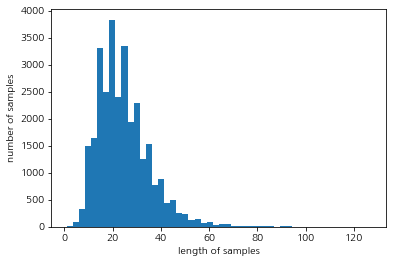

In [14]:
# text 토큰화, text 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(Text_train)
sequences = tokenizer.texts_to_sequences(Text_train)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('단어 집합(Vocabulary)의 크기 :',vocab_size)

# 문장의 길이파악 >> 패딩 사이즈를 정하기 위해
print('문장의 최대 길이 :',max(len(l) for l in sequences))
print('문장의 평균 길이 :',sum(map(len, sequences))/len(sequences))
plt.hist([len(s) for s in sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [15]:
max_len = 133
# 각각의 문장을 토큰화 한것을 166개로 지정된(패딩된) 리스트에 정수 인코딩
Text_train = pad_sequences(sequences, maxlen = max_len)

# 라벨은 다중 클래스 분류를 위한 원핫인코딩
Label_train = to_categorical(np.asarray(Label_train))
print('전체 데이터의 크기(shape):', Text_train.shape)
print('레이블 데이터의 크기(shape):', Label_train.shape)


전체 데이터의 크기(shape): (29734, 133)
레이블 데이터의 크기(shape): (29734, 9)


In [16]:
print(Text_train[0])
print(Label_train[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     1
    20  4343    22  1225   358 32929     2   285   575   146   272   696
  1225  2755   809 54123   285  1911    35    15   289    13  2161  2854
 54124]
[0. 0. 0. 0. 0. 0. 0. 1. 0.]
